In [64]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Reshape

In [65]:
df = pd.read_csv('./data/bitcoin_data_test.csv')
print(df)

      candle_date_time_kst  opening_price  high_price  low_price  trade_price   
0      2023-05-01T08:00:00       39319000    39370000   39108000     39149000  \
1      2023-05-01T07:00:00       39332000    39374000   39299000     39300000   
2      2023-05-01T06:00:00       39254000    39420000   39241000     39331000   
3      2023-05-01T05:00:00       39260000    39291000   39052000     39254000   
4      2023-05-01T04:00:00       39465000    39468000   39084000     39260000   
...                    ...            ...         ...        ...          ...   
48966  2017-09-25T20:00:00        4204000     4204000    4175000      4191000   
48967  2017-09-25T19:00:00        4213000     4213000    4187000      4204000   
48968  2017-09-25T17:00:00        4235000     4235000    4235000      4235000   
48969  2017-09-25T13:00:00        4222000     4235000    4208000      4235000   
48970  2017-09-25T12:00:00        4201000     4244000    4191000      4202000   

       candle_acc_trade_pri

In [66]:
# 데이터 전처리
df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst']) #datetime 변환
df.set_index('candle_date_time_kst', inplace=True)

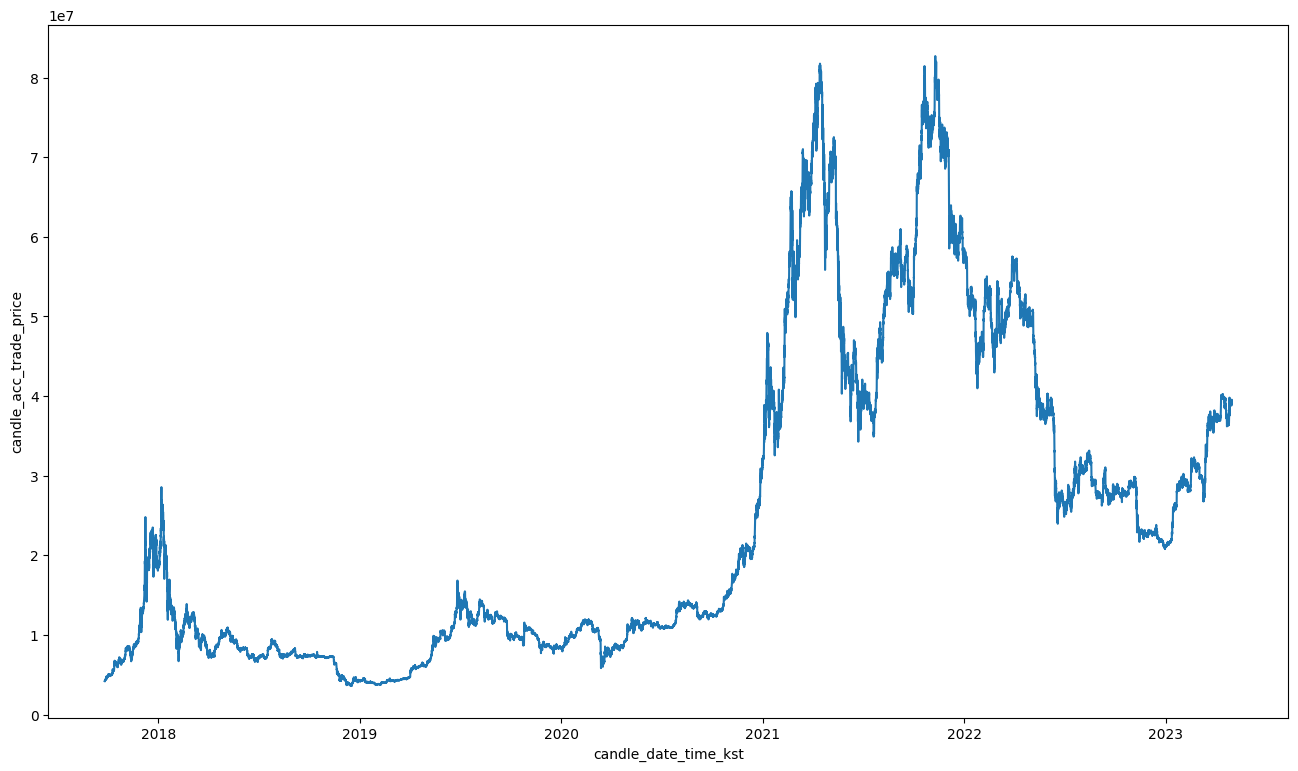

In [49]:
# 데이터 확인하기
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y="trade_price", data=df)
plt.xlabel("candle_date_time_kst")
plt.ylabel("candle_acc_trade_price")
plt.show()

asfreq() 함수를 사용하여 결측치를 처리합니다. 

In [67]:
# 결측치 처리
df = df.asfreq('60T') #60 간격마다 보관 시계열이용하기위한
df = df.interpolate(method='linear')

MinMaxScaler()를 사용하여 데이터를 정규화합니다

In [68]:
# 데이터 정규화
scaler = MinMaxScaler()
scale_cols = ['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']
scaled = scaler.fit_transform(df[['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']])

# 데이터 셋 만들기
df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

       opening_price  high_price  low_price  trade_price   
0           0.007925    0.008280   0.008014     0.007937  \
1           0.008191    0.008166   0.008231     0.008354   
2           0.008232    0.008166   0.008317     0.008354   
3           0.008273    0.008166   0.008403     0.008354   
4           0.008314    0.008166   0.008489     0.008354   
...              ...         ...        ...          ...   
49048       0.453650    0.453527   0.452579     0.451008   
49049       0.451059    0.451290   0.452171     0.450932   
49050       0.450983    0.452921   0.454579     0.451905   
49051       0.451969    0.452339   0.455318     0.451513   
49052       0.451805    0.452289   0.452885     0.449605   

       candle_acc_trade_price  candle_acc_trade_volume  
0                    0.000959                 0.007116  
1                    0.000075                 0.000555  
2                    0.000056                 0.000416  
3                    0.000037                 0.000

전체 데이터를 학습, 검증, 테스트 데이터로 분리합니다. 이 예시에서는 7:2:1 비율로 분리합니다. train_size, val_size, test_size 변수를 사용하여 데이터를 분리합니다.

In [69]:
# 데이터셋 분리 비율
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
'''
# 학습 데이터와 테스트 데이터로 분리
train_val_data, test_data = train_test_split(df, test_size=test_ratio, shuffle=False) #test_size 는 비율의미 shuffle=False 로 한이유는 시계열 특성을 고려?

# 학습 데이터와 검증 데이터로 분리
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False)
'''
# 학습 데이터와 테스트 데이터로 분리
test_data_size = int(len(df) * test_ratio)
train_val_data = df[:-test_data_size]
test_data = df[-test_data_size:]

# 학습 데이터와 검증 데이터로 분리
val_data_size = int(len(train_val_data) * val_ratio / (train_ratio + val_ratio))
train_data = train_val_data[:-val_data_size]
val_data = train_val_data[-val_data_size:]


In [57]:
print(train_val_data)
print('-------------------------------------------------------------------')
print(test_data)
print('-------------------------------------------------------------------')
print(train_data)
print('-------------------------------------------------------------------')
print(val_data)


       opening_price  high_price  low_price  trade_price   
0           0.007925    0.008280   0.008014     0.007937  \
1           0.008191    0.008166   0.008231     0.008354   
2           0.008232    0.008166   0.008317     0.008354   
3           0.008273    0.008166   0.008403     0.008354   
4           0.008314    0.008166   0.008489     0.008354   
...              ...         ...        ...          ...   
44143       0.306284    0.306721   0.308557     0.306123   
44144       0.306234    0.306519   0.308455     0.306540   
44145       0.306575    0.306481   0.308646     0.306540   
44146       0.306575    0.306607   0.308722     0.306502   
44147       0.306537    0.306367   0.308391     0.306325   

       candle_acc_trade_price  candle_acc_trade_volume  
0                    0.000959                 0.007116  
1                    0.000075                 0.000555  
2                    0.000056                 0.000416  
3                    0.000037                 0.000

filters 특정한 종류의 합성곱수행하는맵
kernel_size 필터크기설정 필가입력시 데이터 추출패턴크기정하기
activation 0보다 작은거 0으로 큰거 그대로출력
input_shape 모델의 첫 번째 레이어로 사용되는 경우, 입력 데이터의 크기를 설정합니다. n_timesteps는 입력 데이터의 시계열 길이를 나타내고, n_features는 입력 데이터의 특징 수를 나타냅니다.
Dropout은 오버피팅을 방지하기 위해 사용되는 기법

In [70]:
#CNN 모델 LSTM모델 
n_timesteps = 24
n_features = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Reshape((-1, 64)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [71]:
#모델 학습하기
# 학습하기
history = model.fit(train_data, validation_data=val_data, epochs=50, batch_size=32)

# 평가하기
score = model.evaluate(test_data)
print("Test loss:", score)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().